# Strong Lensing Challenge - Regression

Since its discovery via its gravitational interactions over half a century ago, the identity of dark matter has yet to be found. This is despite countless experiments aimed at detection of the most promising dark matter candidates. An alternative to terrestial detection (for example, with colliders or liquid xenon) for dark matter identification is unique gravitational signatures which arise from disparte substructure predicitions among dark matter models. Example substructures include subhalos of WIMP-like cold dark matter and vortices of superfluid dark matter. Perhaps the most promising method to infer the unique morphology of these substructures is with strong galaxy-galaxy lensing images; an intermediate dark matter halo (which contains a visible galaxy) lenses a galaxy which is behind it.

In this challenge we will use regression to measure the total fraction of mass in substructure of a dark matter halo. We will do so utilizing simulated strong lensing images with subahlo substructure consistent with non-interacting cold dark matter models.

In this notebook, we present a simple model implemented using the PyTorch library to solve a regression task for strong lensing images. Specifically, the task is to learn the total fraction of mass in substructure of a dark matter halo, i.e. $f_{sub} = m_{sub}/m_{halo}$ where $m_{sub}$ is the mass in substructure and $m_{halo}$ is the mass of the dark matter halo.

### Dataset

The dataset consists of *simulated* strong lensing images with cold dark matter subhalos generated by PyAutoLens. It contains 25k grayscale images with the size of 150x150 and the corresponding $f_{sub}$ which is known from simulations and should be $\sim \mathcal{O}(1\%)$.


### Evaluation Metric

* MAE (Mean Absolute Error)

### Instructions for using the notebook

1. Use GPU acceleration: (Edit --> Notebook settings --> Hardware accelerator --> GPU)
2. Run the cells: (Runtime --> Run all)



## Download Dataset

In [ ]:
# !gdown http://drive.google.com/uc?id=1hu472ALwGPBcTCXSAM0VoCWmTktg9j-j

In [ ]:
# !tar zxvf lens_data_alt.tgz

In [ ]:
import numpy as np
import os
import matplotlib
import matplotlib.pyplot as plt

%matplotlib inline

import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader
import torchvision
from torchvision import transforms

## Load Dataset

In [ ]:
DATASET_PATH = './lens_data'
images = []
# f_sub -> mass fraction
f_subs = []
for f_name in os.listdir(DATASET_PATH):
    img, mass = np.load(os.path.join(DATASET_PATH,f_name),allow_pickle=True)
    # Add img and mass to separate lists
    # Add 1 as the first dimension for image
    images.append(img.reshape(1,img.shape[0],img.shape[1]))
    # Convert mass to a single element array with (1,1) dimensions
    f_subs.append(np.array(mass,ndmin=1))

# Images shape is (num_of_images,1,150,150)
images = np.stack(images).astype('float32')
# Mass fractions shape is (num_of_images,1)
f_subs = np.stack(f_subs).astype('float32')

## Plot Strong Lensing Images

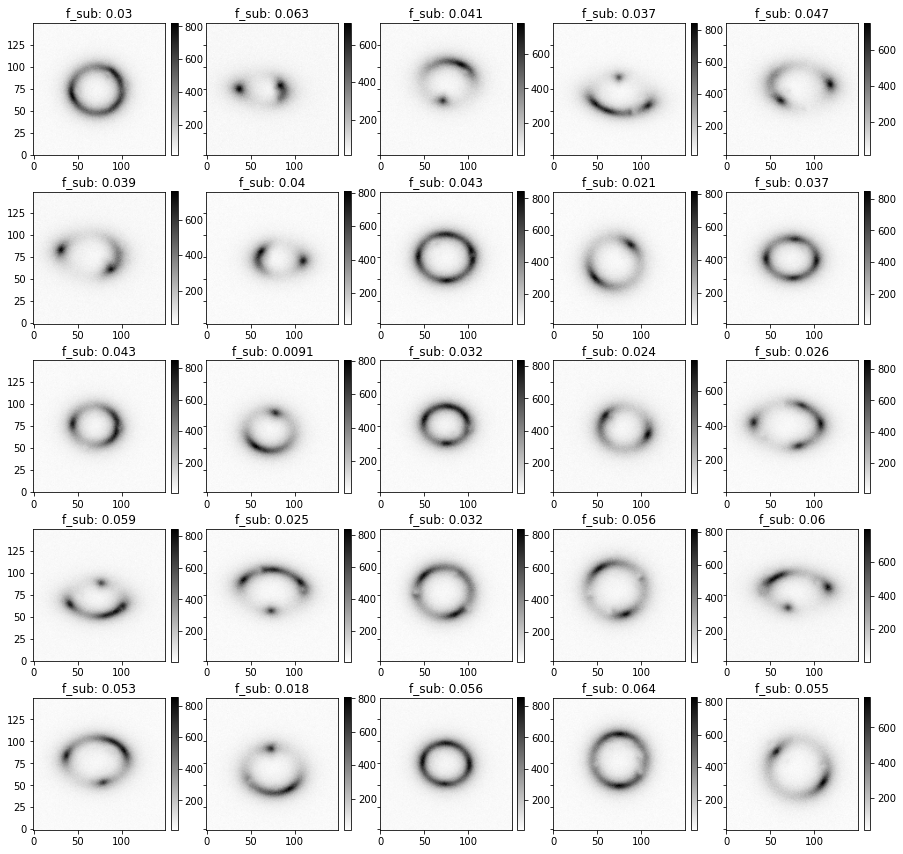

In [ ]:
# Will plot only first 4 lenses 
grid_size = (5,5)
figure,axis = plt.subplots(grid_size[0],grid_size[1],figsize=(15,15),sharey=True)
img_indx=0

for i in range(grid_size[0]):
    for j in range(grid_size[1]):
        # Plotting image
        img = axis[i][j].imshow(images[img_indx][0], cmap='binary', origin='lower')
        # Setting up a title
        axis[i][j].set_title(f'f_sub: {f_subs[img_indx][0]:.2}')
        # Plotting a colorbar to show the intensity of pixels
        plt.colorbar(img,ax=axis[i][j],fraction=0.046, pad=0.04)
        img_indx+=1
plt.show()

Text(0.5, 0, 'f_subs')

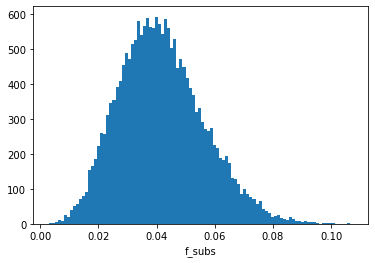

In [ ]:
_=plt.hist(f_subs.flatten(),bins=100)
plt.xlabel("f_subs")

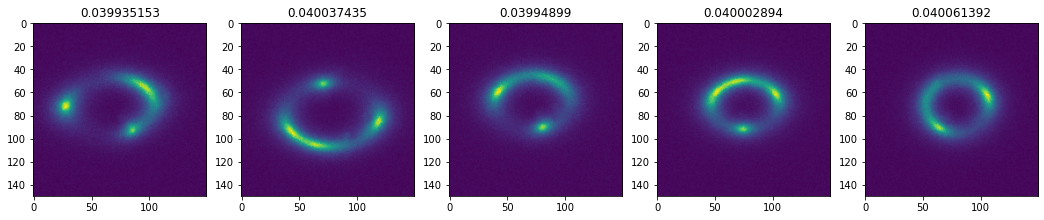

In [ ]:
idxs=(np.abs(f_subs.flatten()-0.04)<0.0001)
selected_imgs=images[idxs]
selected_fsubs=f_subs.flatten()[idxs]

fig,axes=plt.subplots(1,5,figsize=(18,4))
for iax, ax in enumerate(axes):
    try:
        ax.imshow(selected_imgs[iax].reshape(150,150))
        ax.set_title(selected_fsubs[iax])
    except:
        pass

wow, even very small differences in f_sub shows very big differences

## Standardization


In [ ]:
# Applies z-standartization to make the dataset mean=0 and std=1
def standardize(element,STD,MEAN):
    return (element - MEAN) / STD
# Cancel the effect of z-standartization
def inv_standardize(element,STD,MEAN):
    return element * STD + MEAN

# Find stats of the dataset
IMAGES_MEAN, IMAGES_STD = images.mean(), images.std()
F_SUB_MEAN, F_SUB_STD = f_subs.mean(), f_subs.std()

# Standardize the dataset
images=standardize(images,IMAGES_STD,IMAGES_MEAN)
f_subs=standardize(f_subs,F_SUB_STD,F_SUB_MEAN)

## Create Custom Dataset

In [ ]:
class RegressionNumpyArrayDataset(Dataset):
    def __init__(self,x,y,indexes=None,x_transforms_func = None):
        self.x = x[indexes]
        self.y = y[indexes]

        # Transforms that will be aplied to the every batch of lenses.
        # x_transforms_func must be callable.
        self.x_transforms = x_transforms_func


    def __len__(self):
        # Returns the length of the dataset
        return self.x.shape[0]

    def __getitem__(self, idx):
        # Returns an (image, label) tuple
        image, label = self.x[idx], self.y[idx]

        # Convert to Tensor and Float
        image = torch.tensor(image).float()
        label = torch.tensor(label).float()

        # Apply transforms
        if self.x_transforms!=None:
            image= self.x_transforms(image)

        return  image , label 

## Split Dataset

In [ ]:
train_indx = np.arange(0,15000)#np.arange(0,13000)
test_indx = np.arange(15000,20000)

## Image Augmentation

In [ ]:
base_image_transforms = transforms.Compose([
    transforms.Resize(150)
])

In [ ]:
# Create instanses of test and train datasets
train_dataset = RegressionNumpyArrayDataset(images, f_subs, train_indx,
                                            base_image_transforms)
test_dataset = RegressionNumpyArrayDataset(images, f_subs, test_indx,                                 
                                           base_image_transforms)

# Create instanses of dataloaders
batch_size = 128

train_data_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2)
test_data_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=2)

## Regression Models

In [ ]:
class LinearRegression(torch.nn.Module):
    def __init__(self, inputSize, outputSize):
        super(LinearRegression, self).__init__()
        self.linear = torch.nn.Linear(inputSize, outputSize)

    def forward(self, x):
        # Flat dimensions before applying the linear layer
        flatten_x = torch.flatten(x,start_dim=1)
        out = self.linear(flatten_x)
        return out

class Resnet18Regression(torch.nn.Module):
    def __init__(self, num_of_input_channels, output_size):
        super(Resnet18Regression, self).__init__()
        self.resnet18 = torchvision.models.resnet18()
        # Change the input number of channels to 1 to make it work on grayscale images
        self.resnet18.conv1 = torch.nn.Conv2d(num_of_input_channels, 64, kernel_size=(5, 5), 
                                 stride=(2, 2), padding=(3, 3), bias=False)
        # Change the output size to 1 to predict a mass density
        self.resnet18.fc = torch.nn.Linear(in_features=512, out_features=output_size, 
                                           bias=True)

    def forward(self, x):
        out = self.resnet18(x)
        return out

## Loss Function

In [ ]:
def mse_loss(pred, true):
    loss = (pred-true).pow(2)
    return loss.mean()

# Mean Absolute Error is used as the main metric for measuring the performance of the model.
def mae_loss(pred, true):
    loss = torch.abs(pred-true)
    return loss.mean()

## Training

In [ ]:
torch.cuda.set_device(1)

In [ ]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f'Device: {device}')

# Create an instanse of the model.
# 150*150 = 22500
# model = LinearRegression(22500,1).to(device)
model = Resnet18Regression(1,1).to(device)

Device: cuda


In [ ]:
# Optimizer
lr = 3e-4
weight_decay = 3e-5
num_of_epochs = 50

optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)

In [ ]:
# Start the training loop
train_loss_array=[]
val_loss_array=[]
counter=0
for i in range(num_of_epochs):
    # print("\n\n\nTRAINING")
    #### TRAINING PHASE
    # model.train()
    train_epoch_loss = 0
    train_num_of_steps_in_epoch = 0
    # print("==============================================")
    # print(f'{train_epoch_loss},{train_num_of_steps_in_epoch}')
    for step, (images_batch, f_subs_batch) in enumerate(train_data_loader):
        # Use GPU if available
        if torch.cuda.is_available():
            images_batch = images_batch.cuda()
            f_subs_batch = f_subs_batch.cuda()
        optimizer.zero_grad()
        # RUN the model
        predicted_f_subs = model(images_batch)
        # print(images_batch)
        # Calculate loss
        loss = mse_loss(predicted_f_subs,f_subs_batch)
        # Calculate gradient
        loss.backward()
        # Do an optimization step
        optimizer.step()
        train_epoch_loss+=loss
        train_num_of_steps_in_epoch+=1
        # print(f'{train_epoch_loss},{train_num_of_steps_in_epoch}')
    train_loss_w = (train_epoch_loss/train_num_of_steps_in_epoch).detach().item()
    train_loss_array.append(train_loss_w)
    
    #### VALIDATION PHASE
    # print("VALIDATING")
    # model.eval() ### EVAL HAS DIFFERENT PROPERTIES FOR BATCHNORM IN RESNET. LOSS VARIES GREATLY WITH EVAL ON
    with torch.no_grad():
        val_epoch_loss = 0
        val_num_of_steps_in_epoch = 0
        # print("==============================================")
        # print(f'{val_epoch_loss},{val_num_of_steps_in_epoch}')
        for step, (images_batch, f_subs_batch) in enumerate(test_data_loader):
            # Use GPU if available
            if torch.cuda.is_available():
                images_batch = images_batch.cuda()
                f_subs_batch = f_subs_batch.cuda()
            # RUN the model
            predicted_f_subs = model(images_batch)
            # print(images_batch)
            # Calculate loss
            loss = mse_loss(predicted_f_subs,f_subs_batch)
            val_epoch_loss+=loss
            val_num_of_steps_in_epoch+=1
            # print(f'{val_epoch_loss},{val_num_of_steps_in_epoch}')
        val_loss_w = (val_epoch_loss/val_num_of_steps_in_epoch).detach().item()
        val_loss_array.append(val_loss_w)
        
    # # some form of early stopping. If the val loss does not improve over 3 epochs then we stop
    # minimum=min(val_loss_array)
    # if val_loss_w-minimum > 0:
    #     counter+=1
    # else:
    #     counter=0
    # if counter>=2:
    #     break
    
    #### FINALIZE
    print(f'Epoch {i+1} train/val loss: {train_loss_w:.5f}/{val_loss_w:.5f}/{counter}')

Epoch 1 train/val loss: 0.09121/0.85339/0
Epoch 2 train/val loss: 0.10151/0.83108/0
Epoch 3 train/val loss: 0.09172/0.84476/0
Epoch 4 train/val loss: 0.07439/0.81498/0
Epoch 5 train/val loss: 0.06888/0.84943/0
Epoch 6 train/val loss: 0.06718/0.83376/0
Epoch 7 train/val loss: 0.05497/0.81041/0
Epoch 8 train/val loss: 0.05688/0.82604/0
Epoch 9 train/val loss: 0.05354/0.82662/0
Epoch 10 train/val loss: 0.05731/0.80588/0
Epoch 11 train/val loss: 0.05563/0.79102/0
Epoch 12 train/val loss: 0.05432/0.81733/0
Epoch 13 train/val loss: 0.05338/0.83562/0
Epoch 14 train/val loss: 0.04841/0.82704/0
Epoch 15 train/val loss: 0.05219/0.83093/0
Epoch 16 train/val loss: 0.04746/0.82523/0
Epoch 17 train/val loss: 0.04392/0.80081/0
Epoch 18 train/val loss: 0.04216/0.79773/0
Epoch 19 train/val loss: 0.04250/0.81743/0
Epoch 20 train/val loss: 0.04519/0.82275/0
Epoch 21 train/val loss: 0.04329/0.82223/0
Epoch 22 train/val loss: 0.04404/0.83262/0
Epoch 23 train/val loss: 0.04735/0.81776/0
Epoch 24 train/val l

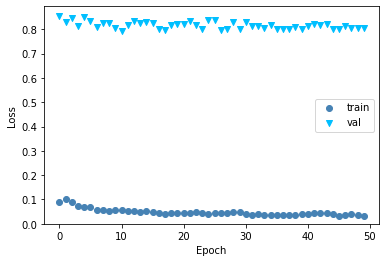

In [ ]:
skip=0
plt.scatter(np.arange(num_of_epochs)[skip:len(train_loss_array)],torch.tensor(train_loss_array).numpy()[skip:],c="steelblue",marker='o',label="train")
plt.scatter(np.arange(num_of_epochs)[skip:len(train_loss_array)],torch.tensor(val_loss_array).numpy()[skip:],c="deepskyblue",marker='v',label="val")
plt.ylabel("Loss")
plt.xlabel("Epoch")
plt.ylim(bottom=0)#,top=0.003)
plt.legend()

## Testing

In [ ]:
def np_mae_loss(pred, true):
    loss = np.abs(pred-true)
    return loss.mean()#/len(pred)

In [ ]:
# Run the model on the test dataset
predicted_f_subs_list = []
real_f_subs_list = []
for step, (ximages, xf_subs) in enumerate(test_data_loader):
    # Use GPU if available
    if torch.cuda.is_available():
        ximages = ximages.cuda()
        xf_subs = xf_subs.cuda()

    # RUN the model
    predicted_f_subs = model(ximages)
    predicted_f_subs_list.append(predicted_f_subs.cpu().detach().numpy())
    real_f_subs_list.append(xf_subs.cpu().numpy())


# Remove the last batch of the results to make all the arrays in the list the same size
del predicted_f_subs_list[-1]
del real_f_subs_list[-1]

## Plot the results

MAE: 0.010351368226110935


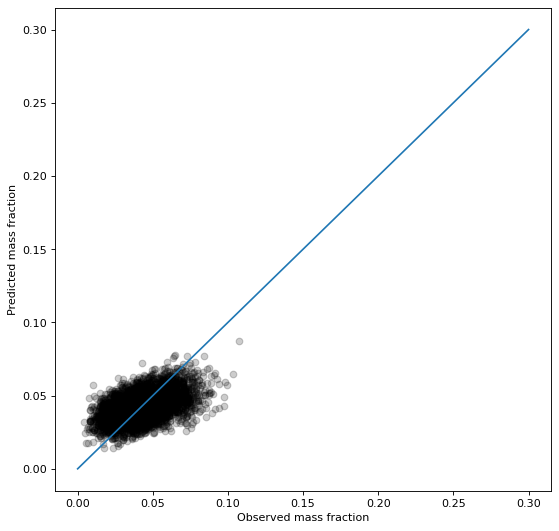

In [ ]:
# PLOTTING TEST RESULTS
predicted_f_subs_arr = np.concatenate(predicted_f_subs_list)
real_f_subs_arr = np.concatenate(real_f_subs_list)

m_pred,m_true = inv_standardize(predicted_f_subs_arr,F_SUB_STD,F_SUB_MEAN),inv_standardize(real_f_subs_arr,F_SUB_STD,F_SUB_MEAN)
# m_pred,m_true = predicted_f_subs_arr, real_f_subs_arr


test_mae = np_mae_loss(m_pred,m_true)
plt.figure(figsize=(8,8),dpi=80)
plt.scatter(m_true, m_pred,  color='black',alpha=0.2)
line = np.linspace(0, 0.3, 10)
plt.plot(line, line)
plt.xlabel('Observed mass fraction')
plt.ylabel('Predicted mass fraction')
print(f'MAE: {test_mae}')
#plt.text(1,4, 'MAE: {:.4f}'.format(test_mae))

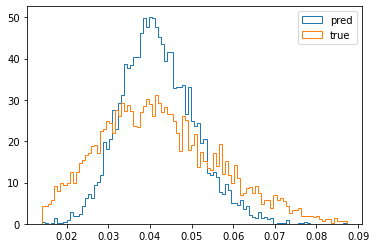

In [ ]:
out = plt.hist(m_pred.flatten(),bins=100,density=True,histtype='step',label='pred')
plt.hist(m_true.flatten(),bins=out[1],density=True,histtype='step',label='true')
plt.legend()

## Save the model

In [ ]:
SAVE_PATH = 'trained_regressor_dark_matter'
torch.save(model.state_dict(), SAVE_PATH)

## Submission Guidelines 

* You are required to submit a Google Colab Jupyter Notebook clearly showing your implementation along with the evaluation metrics (MAE) for the training and validation data.
* You also have to submit the final trained model, including the model architecture and the trained weights ( For example: HDF5 file, .pb file, .pt file, etc. )
* You can use this example notebook as a template for your work.
+ The model performance will be evaluated on the hidden dataset based on the above metrics. 

> **_NOTE:_**  You are free to use any ML framework such as PyTorch, Keras, TensorFlow, etc.